In [1]:
import pandas as pd
import numpy as np
import math
import pennylane as qml
import random
import tensorflow as tf

## Brief Outline

The notebook will proceed in the following manner:

1. Brief description of Data
2. Defining QNN and using it to perform stock price prediction


## 1. Data

First, we read in the data, dropping the index and the date.

In [2]:
df = pd.read_csv('dataset_FTSE_prediction_v1.csv')
df = df.drop(['Unnamed: 0'], axis=1)
# df=df.drop(columns=['ARIMA'])
df=df[:1000]

We identify the dependent and independent variables:

In [3]:
target = "Close"

In [4]:
features = list(df.columns.difference(["Close"]))
features

['Adj Close',
 'BBB_20_2.0',
 'BBL_20_2.0',
 'BBM_20_2.0',
 'BBP_20_2.0',
 'BBU_20_2.0',
 'CUMLOGRET_1',
 'Close_copy',
 'Crude Futures',
 'EMA_10',
 'EMA_20',
 'EMA_50',
 'FT3',
 'FT6',
 'FT9',
 'GBP USD ',
 'Gold in USD',
 'MACD_12_26_9',
 'MACDh_12_26_9',
 'MACDs_12_26_9',
 'SMA_10',
 'SMA_20',
 'SMA_50',
 'Volume']

## Data Processing

To process the data, we first define few terms

In [5]:
random.seed(42)

Next, in order to ensure that some values due to their mangnitude do not inherently dominate the features, we standardize their values.

In [6]:
target_mean = df[target].mean()
target_stdev = df[target].std()

for c in df.columns:
    mean = df[c].mean()
    stdev = df[c].std()

    df[c] = (df[c] - mean) / stdev

In [7]:
df

,Adj Close,BBB_20_2.0,BBL_20_2.0,BBM_20_2.0,BBP_20_2.0,BBU_20_2.0,CUMLOGRET_1,Close,Crude Futures,EMA_10,...,GBP USD,Gold in USD,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,SMA_10,SMA_20,SMA_50,Volume,Close_copy
0,-1.683788,-2.036569,-6.119758,-6.215784,-1.576248,-6.275358,-1.722925,-1.683788,0.715028,-7.986904,...,0.791322,1.861594,-0.256965,0.013277,-0.293347,-7.974110,-6.215784,-4.163501,1.061571,-1.683788
1,-1.928550,-2.036569,-6.119758,-6.215784,-1.576248,-6.275358,-2.002803,-1.928550,0.611988,-7.986904,...,0.606822,2.090899,-0.256965,0.013277,-0.293347,-7.974110,-6.215784,-4.163501,0.375712,-1.928550
2,-2.294438,-2.036569,-6.119758,-6.215784,-1.576248,-6.275358,-2.433936,-2.294438,0.611988,-7.986904,...,0.606822,2.090899,-0.256965,0.013277,-0.293347,-7.974110,-6.215784,-4.163501,0.216701,-2.294438
3,-2.189733,-2.036569,-6.119758,-6.215784,-1.576248,-6.275358,-2.308947,-2.189733,0.641428,-7.986904,...,0.422321,2.072632,-0.256965,0.013277,-0.293347,-7.974110,-6.215784,-4.163501,0.928938,-2.189733
4,-1.877164,-2.036569,-6.119758,-6.215784,-1.576248,-6.275358,-1.943493,-1.877164,0.794410,-7.986904,...,0.053321,1.804868,-0.256965,0.013277,-0.293347,-7.974110,-6.215784,-4.163501,0.439031,-1.877164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.999709,-0.029876,0.637243,0.643441,-0.152500,0.645966,0.976688,0.999709,-1.970825,0.716082,...,-0.315680,-1.284748,-1.206908,0.656828,-1.641128,0.671557,0.643441,0.647618,-0.387877,0.999709
996,0.895198,-0.215551,0.642165,0.631833,-0.562964,0.618332,0.882308,0.895198,-1.967670,0.706288,...,-0.315680,-1.278018,-1.220334,0.500655,-1.587679,0.667567,0.631833,0.644271,-0.650815,0.895198
997,0.637879,-0.167381,0.621381,0.615072,-1.629896,0.605579,0.646672,0.637879,-2.033384,0.667259,...,-0.315680,-1.251098,-1.466207,-0.099759,-1.600075,0.656060,0.615072,0.638275,0.098631,0.637879
998,0.445662,0.126202,0.575433,0.594578,-2.058484,0.609970,0.467538,0.445662,-1.950322,0.612159,...,-0.315680,-1.284748,-1.829071,-0.819398,-1.691391,0.631881,0.594578,0.630746,0.639817,0.445662


In [15]:
# Data for regression model
sequence_length_reg = window_reg =30 # Number of time steps that will be inputted into LSTM network

def create_dataset_reg(dataset,target,features, lookback, window):
    X_store, y_store = [], []
    for i in range(0,len(dataset)-lookback-window,5):
        X = (dataset[features].values)[i:i+lookback]
        y = (dataset[target].values)[i+lookback-1:i+lookback+window-1]
        X_store.append(X)
        y_store.append(y)
    return X_store,y_store

X_reg,y_reg = create_dataset_reg(
    df,
    target=target,
    features=features,
    lookback=sequence_length_reg, window=window_reg)

print(np.array(X_reg).shape, np.array(y_reg).shape)

(188, 30, 24) (188, 30)


In [16]:
indices = tf.range(start=0, limit=tf.shape(X_reg)[0])
shuffled_indices = tf.random.shuffle(indices)

In [17]:
X_reg = tf.gather(X_reg, shuffled_indices)
y_reg = tf.gather(y_reg, shuffled_indices)

In [18]:
# Train test split
m=np.array(X_reg).shape[0] # get first dimension
size=int(m*0.9)
X_train_reg=X_reg[:size]
y_train_reg=y_reg[:size]
X_test_reg=X_reg[size:]
y_test_reg=y_reg[size:]
print('Shape of train is',np.array(X_train_reg).shape,'and',np.array(y_train_reg).shape)
print('Shape os test is',np.array(X_test_reg).shape,'and',np.array(y_test_reg).shape)

Shape of train is (169, 30, 24) and (169, 30)
Shape os test is (19, 30, 24) and (19, 30)


In [19]:
X_train_reg_=np.array([inner for outer in X_train_reg for inner in outer])
print(X_train_reg_.shape)
y_train_reg_=np.array([inner for outer in y_train_reg for inner in outer])
print(y_train_reg_.shape)

(5070, 24)
(5070,)


In [20]:
X_test_reg_=np.array([inner for outer in X_test_reg for inner in outer])
print(X_test_reg_.shape)
y_test_reg_=np.array([inner for outer in y_test_reg for inner in outer])
print(y_test_reg_.shape)

(570, 24)
(570,)


In [21]:
# Prepare test data
X_check_reg=(df[features].values)[len(df)-window_reg-sequence_length_reg+1:len(df)- window_reg+1]
y_check_reg=(df[target].values)[len(df)-window_reg:len(df)]

In [22]:
# import torch

# QNN

In [31]:
# Define QNode
n_layers=3
nqubits = 8
device = qml.device('default.qubit.tf', wires=nqubits)
@qml.qnode(device, interface="tf", diff_method="backprop")
def qnode(inputs, weights):
    # Preproccess input data to encode the initial state.
    ry_params = [math.atan(feature) for feature in inputs]
    rz_params = [math.atan(feature**2) for feature in inputs]
    for i in range(nqubits):
        qml.Hadamard(wires=i)
        qml.RY(ry_params[i], wires=i)
        qml.RZ(ry_params[i], wires=i)
    qml.templates.AngleEmbedding(inputs, wires=range(nqubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(nqubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(nqubits)]
# define weight_shapes
weight_shapes = {"weights": (n_layers, nqubits, 3)}

In [32]:
from tensorflow.keras import regularizers, initializers
from tensorflow.keras.layers import Input, Dense, Reshape, Embedding, concatenate, Dropout, Flatten
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import Model

In [33]:
input_ = Input((24,)) # feature
den1=Dense(8, use_bias=True,activation='relu')(input_) 
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=nqubits)(den1)
den5=Dense(1, use_bias=True,activation='linear')(qlayer)
model = Model(inputs=[input_], outputs=den5)

In [34]:
loss_fn = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(opt, loss=loss_fn)

In [35]:
import time

In [ ]:
start=time.time()
model_history = model.fit(X_train_reg_, y_train_reg_,
#                     validation_data=(X_test_reg_, y_test_reg_),
                   batch_size=32, 
                   epochs=10,  # total epoch
                   )
end=time.time()

Epoch 1/10
159/159 [==============================] - 2076s 13s/step - loss: 0.1998
Epoch 2/10
159/159 [==============================] - 2371s 15s/step - loss: 0.0461
Epoch 3/10
 62/159 [==========>...................] - ETA: 21:25 - loss: 0.0356

In [ ]:
print(end-start)

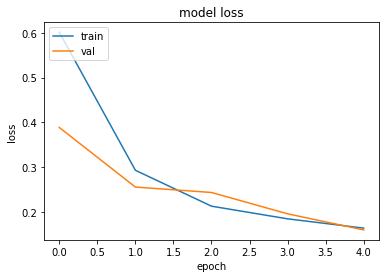

In [101]:
import keras
from matplotlib import pyplot as plt
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [102]:
def mae_metric(actual, predicted):
    sum_error = 0.0
    for i in range(len(actual)):
        sum_error += abs(predicted[i] - actual[i])
    return sum_error/len(actual)

def rmse_metric(actual, predicted):
    sum_error = 0.0
    for i in range(len(actual)):
        sum_error += (predicted[i] - actual[i])**2
    return (sum_error/len(actual))**0.5

In [103]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
y_check_pred_qnn = model.predict(X_check_reg)
y_check_pred_qnn=y_check_pred_qnn.flatten()
mae_check_qnn = mean_absolute_error(y_check_reg* target_stdev + target_mean, y_check_pred_qnn* target_stdev + target_mean)
print('Mean absolute Error : ',mae_check_qnn)
rmse_check_qnn = mean_squared_error(y_check_reg* target_stdev + target_mean, y_check_pred_qnn* target_stdev + target_mean, squared=False)
print('Root Mean Squared Error : ',rmse_check_qnn)

Mean absolute Error :  105.18241210937495
Root Mean Squared Error :  138.3136030831423


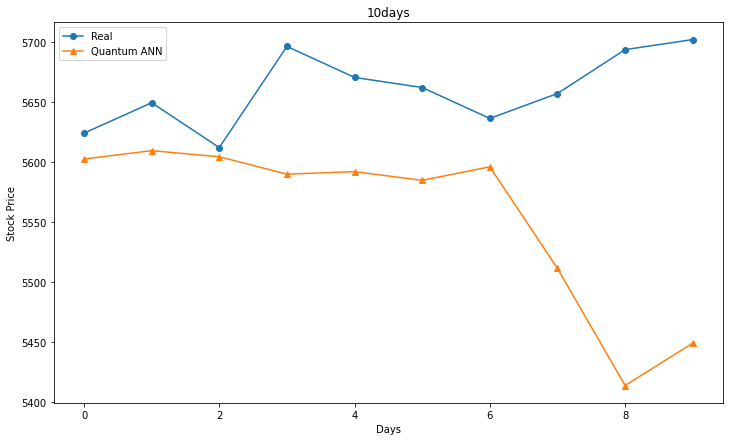

In [104]:
plt.figure(figsize=(12, 7))
plt.plot(y_check_reg* target_stdev + target_mean, label = "Real",marker='o')
plt.plot(y_check_pred_qnn* target_stdev + target_mean, label = "Quantum ANN",marker='^')
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.title(str(window_reg)+'days')
plt.legend()
plt.show()

In [105]:
save_data=[y_check_reg* target_stdev + target_mean,
          y_check_pred_qnn* target_stdev + target_mean]

In [106]:
import csv 
# name of csv file   
filename = "QNN_result_vqc.csv"
      
# writing to csv file   
with open(filename, 'w') as csvfile:   
    # creating a csv writer object   
    csvwriter = csv.writer(csvfile)     
          
    # writing the data rows   
    csvwriter.writerows(save_data)